# Sampling in Large Language Models

This notebook explores sampling techniques used in LLMs, with concise explanations and practical examples.

In [ ]:
# Install required libraries
!pip install numpy matplotlib seaborn

## Why Sampling?

LLMs are deterministic, but we often want variety in responses. Sampling introduces controlled randomness in token selection.

In [2]:
from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

## Our Model Simulator

We'll use a simplified model that generates logits (unnormalized scores) for potential next tokens.

In [3]:
class DummyGPT():
    """Simulates a GPT model with a small vocabulary"""

    def __init__(self, vocab_size=10, seed=10):
        self.vocab_size = vocab_size  # Last token is EOS
        self.seed_start = seed
        self.rng = np.random.default_rng(self.seed_start)
        
        # Token names for visualization
        self.token_names = [f"token_{i}" for i in range(self.vocab_size-1)]
        self.token_names.append("EOS")

    def forward(self, x: Union[list, np.ndarray]) -> np.ndarray:
        """Generate logits for the next token"""
        x = np.array(x)
        if x.ndim != 1:
            raise ValueError("Input x must be a 1D array")
        
        # Generate deterministic logits based on input
        seed = np.sum(x) + len(x) + np.sum(x * np.arange(len(x)))
        rng = np.random.default_rng(self.seed_start + seed)
        logits = (rng.random(self.vocab_size) - 0.5) * 2

        return logits
    
    def softmax(self, logits: Union[list, np.ndarray], temperature=1.0) -> np.ndarray:
        """Convert logits to probabilities with temperature scaling"""
        scaled_logits = logits / temperature
        exp_logits = np.exp(scaled_logits - np.max(scaled_logits))  # For numerical stability
        return exp_logits / np.sum(exp_logits)
    
    def visualize_probabilities(self, probs, title="Token Probabilities"):
        """Visualize probability distribution"""
        plt.figure(figsize=(10, 4))
        bars = plt.bar(self.token_names, probs, color=sns.color_palette("viridis", n_colors=len(probs)))
        
        # Add probability values on bars
        for bar, prob in zip(bars, probs):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prob:.3f}', ha='center', va='bottom', rotation=0)
            
        plt.title(title)
        plt.xlabel("Tokens")
        plt.ylabel("Probability")
        plt.ylim(0, max(probs) + 0.1)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    def token_to_text(self, tokens: Union[list, np.ndarray]) -> str:
        """Convert token IDs to readable names"""
        return " → ".join([self.token_names[int(t)] for t in tokens])

Input: token_4 → token_0 → token_1
Sum of probabilities: 1.000000


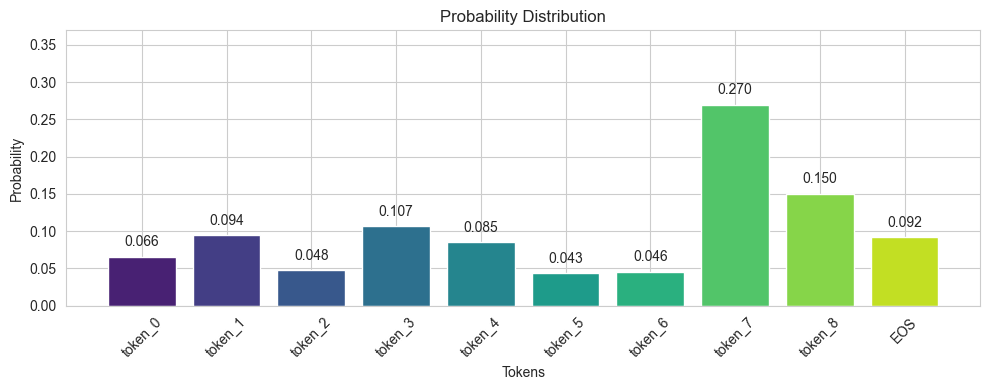

In [4]:
# Initialize model and test
model = DummyGPT()
input_tokens = np.array([4, 0, 1])
print(f"Input: {model.token_to_text(input_tokens)}")

# Get logits and convert to probabilities
logits = model.forward(input_tokens)
probs = model.softmax(logits)
print(f"Sum of probabilities: {np.sum(probs):.6f}")

# Visualize
model.visualize_probabilities(probs, "Probability Distribution")

## 1. Greedy Decoding

The simplest approach: always select the token with highest probability.

In [5]:
def greedy_decode(model, input_tokens, max_tokens=10):
    """Always select the most probable token"""
    input_tokens = np.array(input_tokens)
    current_tokens = input_tokens.copy()
    generated_tokens = []
    eos_id = model.vocab_size - 1
    
    for _ in range(max_tokens):
        logits = model.forward(current_tokens)
        probs = model.softmax(logits)
        next_token_id = np.argmax(probs)  # Greedy selection
        generated_tokens.append(next_token_id)
        
        if next_token_id == eos_id:  # Stop at EOS
            break
            
        current_tokens = np.append(current_tokens, next_token_id)
    
    return np.array(generated_tokens)

In [6]:
# Test greedy decoding
input_tokens = np.array([4, 0, 1])
print(f"Input: {model.token_to_text(input_tokens)}")

greedy_output = greedy_decode(model, input_tokens)
print(f"Greedy output: {model.token_to_text(greedy_output)}")

# Run again to show determinism
greedy_output2 = greedy_decode(model, input_tokens)
print(f"Identical outputs: {np.array_equal(greedy_output, greedy_output2)}")

Input: token_4 → token_0 → token_1
Greedy output: token_7 → token_7 → token_4 → token_0 → token_7 → token_2 → token_4 → EOS
Identical outputs: True


### Limitations of Greedy Decoding

- **Deterministic**: Same input always produces same output
- **Repetitive**: Can get stuck in loops
- **Lacks creativity**: Doesn't explore alternative paths

## 2. Temperature Sampling

Temperature controls how "focused" or "exploratory" the model's predictions are:
- Low temperature (< 1.0): More focused on high-probability tokens
- High temperature (> 1.0): More exploratory, gives weight to lower-probability tokens

In [7]:
def visualize_temperature_effect(model, tokens, temperatures=[0.5, 1.0, 2.0]):
    """Show how temperature affects probability distribution"""
    logits = model.forward(tokens)
    
    plt.figure(figsize=(12, 8))
    
    for i, temp in enumerate(temperatures):
        plt.subplot(len(temperatures), 1, i+1)
        probs = model.softmax(logits, temperature=temp)
        
        bars = plt.bar(model.token_names, probs, color=sns.color_palette("viridis", n_colors=len(probs)))
        for bar, prob in zip(bars, probs):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prob:.3f}', ha='center', va='bottom', rotation=0)
            
        plt.title(f"Temperature = {temp}")
        plt.xlabel("Tokens")
        plt.ylabel("Probability")
        plt.ylim(0, 1.0)
        plt.xticks(rotation=45)
    
    plt.suptitle(f"Effect of Temperature on Token Probabilities")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

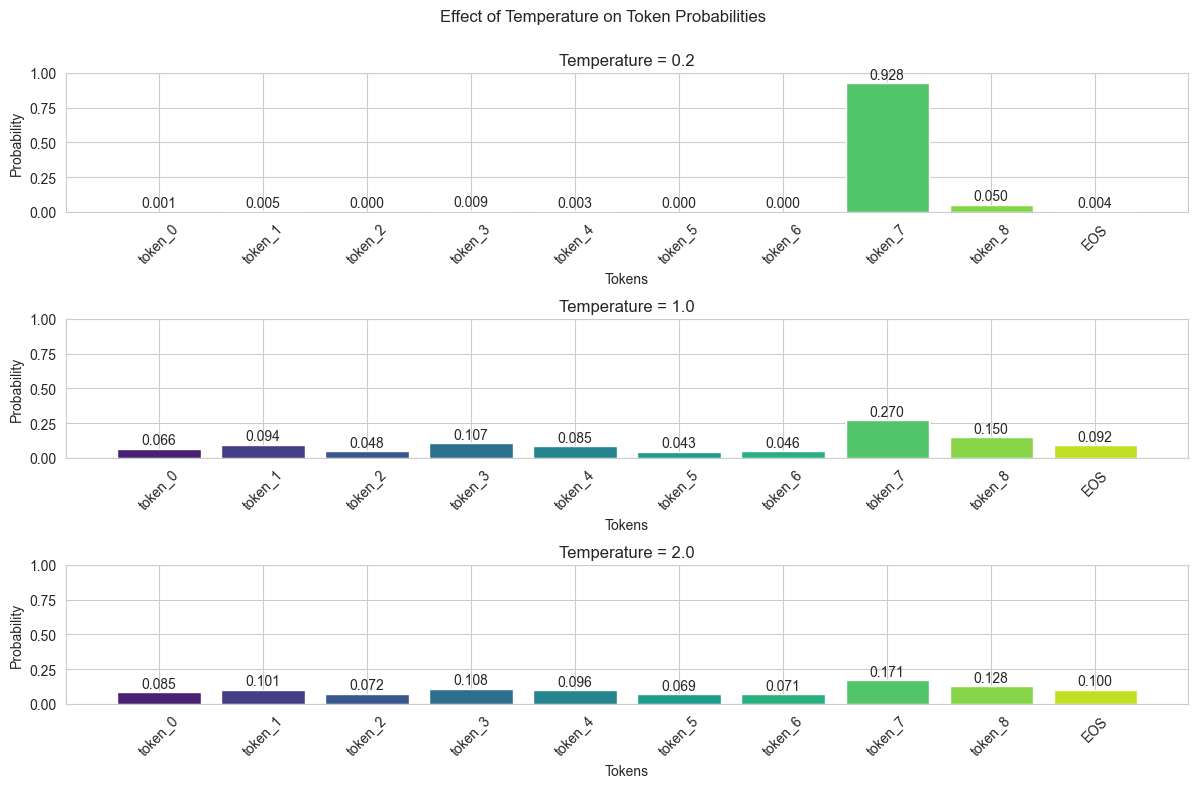

In [8]:
# Visualize temperature effect
visualize_temperature_effect(model, input_tokens, temperatures=[0.2, 1.0, 2.0])

In [9]:
def temperature_sample(model, input_tokens, temperature=1.0, max_tokens=10):
    """Sample with temperature"""
    input_tokens = np.array(input_tokens)
    current_tokens = input_tokens.copy()
    generated_tokens = []
    eos_id = model.vocab_size - 1
    
    for _ in range(max_tokens):
        logits = model.forward(current_tokens)
        probs = model.softmax(logits, temperature=temperature)
        next_token_id = np.random.choice(model.vocab_size, p=probs)  # Sample based on probabilities
        generated_tokens.append(next_token_id)
        
        if next_token_id == eos_id:
            break
            
        current_tokens = np.append(current_tokens, next_token_id)
    
    return np.array(generated_tokens)

In [10]:
# Test temperature sampling
print(f"Input: {model.token_to_text(input_tokens)}\n")

# Low temperature (more focused)
print("Low temperature (T=0.5):")
for _ in range(3):
    output = temperature_sample(model, input_tokens, temperature=0.5)
    print(f"  {model.token_to_text(output)}")

# High temperature (more random)
print("\nHigh temperature (T=2.0):")
for _ in range(3):
    output = temperature_sample(model, input_tokens, temperature=2.0)
    print(f"  {model.token_to_text(output)}")

Input: token_4 → token_0 → token_1

Low temperature (T=0.5):
  token_7 → token_7 → token_1 → token_0 → token_0 → EOS
  token_7 → token_7 → token_2 → token_6 → token_6 → token_0 → token_1 → token_3 → token_2 → token_8
  token_7 → token_3 → token_4 → token_4 → token_2 → token_5 → token_1 → EOS

High temperature (T=2.0):
  token_8 → token_2 → token_1 → token_8 → token_1 → token_2 → token_6 → EOS
  token_2 → token_2 → token_5 → token_3 → token_7 → token_1 → token_1 → token_4 → token_3 → token_8
  token_2 → token_6 → token_5 → token_3 → token_2 → token_3 → token_0 → token_4 → token_7 → EOS


## 3. Top-K Sampling

Top-K sampling restricts sampling to only the K most likely tokens, preventing selection of very unlikely tokens while maintaining diversity.

In [ ]:
def topk_sample(model, input_tokens, k=3, temperature=1.0, max_tokens=10):
    """Sample from top-K most likely tokens"""
    input_tokens = np.array(input_tokens)
    current_tokens = input_tokens.copy()
    generated_tokens = []
    eos_id = model.vocab_size - 1
    
    for _ in range(max_tokens):
        logits = model.forward(current_tokens)
        
        # Get top-k indices and probabilities
        top_k_indices = np.argsort(logits)[-k:]
        top_k_logits = logits[top_k_indices]
        top_k_probs = model.softmax(top_k_logits, temperature=temperature)
        
        # Sample from top-k
        next_token_id = np.random.choice(top_k_indices, p=top_k_probs)
        generated_tokens.append(next_token_id)
        
        if next_token_id == eos_id:
            break
            
        current_tokens = np.append(current_tokens, next_token_id)
    
    return np.array(generated_tokens)

In [12]:
def visualize_topk(model, tokens, k=3):
    """Visualize Top-K sampling"""
    logits = model.forward(tokens)
    probs = model.softmax(logits)
    
    # Get top-k indices
    top_k_indices = np.argsort(probs)[-k:]
    
    # Highlight top-k tokens
    colors = ['lightgray'] * model.vocab_size
    for idx in top_k_indices:
        colors[idx] = 'orange'
    
    plt.figure(figsize=(10, 4))
    bars = plt.bar(model.token_names, probs, color=colors)
    
    for bar, prob in zip(bars, probs):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{prob:.3f}', ha='center', va='bottom', rotation=0)
        
    plt.title(f"Top-{k} Sampling")
    plt.xlabel("Tokens")
    plt.ylabel("Probability")
    plt.ylim(0, max(probs) + 0.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

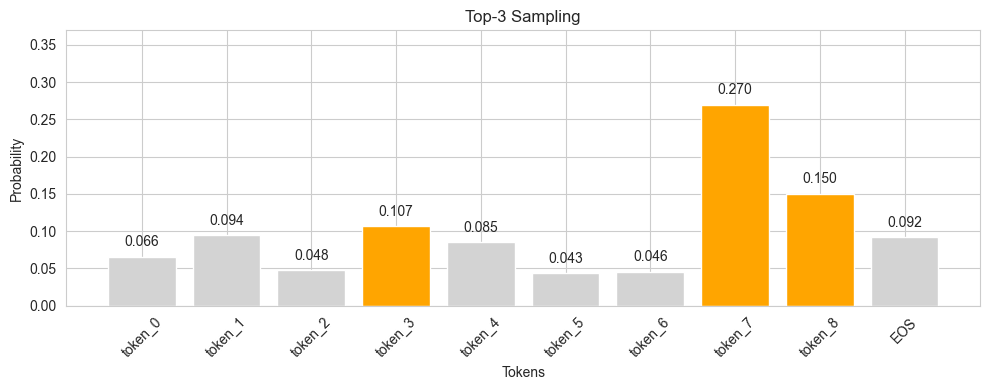

In [13]:
# Visualize Top-K
visualize_topk(model, input_tokens, k=3)

In [14]:
# Test Top-K sampling
print(f"Input: {model.token_to_text(input_tokens)}\n")

print("Top-3 sampling (multiple runs):")
for _ in range(3):
    output = topk_sample(model, input_tokens, k=3)
    print(f"  {model.token_to_text(output)}")

Input: token_4 → token_0 → token_1

Top-3 sampling (multiple runs):
  token_7 → token_6 → token_7 → token_6 → token_4 → token_5 → token_5 → token_0 → token_8 → token_8
  token_3 → token_2 → token_8 → token_0 → token_7 → token_7 → token_8 → token_7 → token_3 → token_2
  token_8 → token_6 → EOS


## 4. Top-P (Nucleus) Sampling

Instead of a fixed K, Top-P selects the smallest set of tokens whose cumulative probability exceeds threshold P.

In [15]:
def topp_sample(model, input_tokens, p=0.9, temperature=1.0, max_tokens=10):
    """Sample from smallest set of tokens with cumulative probability >= p"""
    input_tokens = np.array(input_tokens)
    current_tokens = input_tokens.copy()
    generated_tokens = []
    eos_id = model.vocab_size - 1
    
    for _ in range(max_tokens):
        logits = model.forward(current_tokens)
        probs = model.softmax(logits, temperature=temperature)
        
        # Sort indices by probability (ascending)
        sorted_indices = np.argsort(probs)
        sorted_probs = probs[sorted_indices]
        
        # Find smallest set of tokens with cumulative probability >= p
        cumulative_probs = np.cumsum(sorted_probs)
        cutoff_idx = np.argmax(cumulative_probs >= (1 - p))
        nucleus_indices = sorted_indices[cutoff_idx:]
        
        # Get nucleus probabilities and normalize
        nucleus_probs = probs[nucleus_indices]
        nucleus_probs = nucleus_probs / np.sum(nucleus_probs)
        
        # Sample from nucleus
        next_token_id = np.random.choice(nucleus_indices, p=nucleus_probs)
        generated_tokens.append(next_token_id)
        
        if next_token_id == eos_id:
            break
            
        current_tokens = np.append(current_tokens, next_token_id)
    
    return np.array(generated_tokens)

In [16]:
def visualize_topp(model, tokens, p=0.9):
    """Visualize Top-P sampling"""
    logits = model.forward(tokens)
    probs = model.softmax(logits)
    
    # Sort indices by probability (ascending)
    sorted_indices = np.argsort(probs)
    sorted_probs = probs[sorted_indices]
    
    # Find nucleus
    cumulative_probs = np.cumsum(sorted_probs)
    cutoff_idx = np.argmax(cumulative_probs >= (1 - p))
    nucleus_indices = sorted_indices[cutoff_idx:]
    
    # Highlight nucleus tokens
    colors = ['lightgray'] * model.vocab_size
    for idx in nucleus_indices:
        colors[idx] = 'orange'
    
    plt.figure(figsize=(10, 4))
    bars = plt.bar(model.token_names, probs, color=colors)
    
    for bar, prob in zip(bars, probs):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{prob:.3f}', ha='center', va='bottom', rotation=0)
        
    plt.title(f"Top-P (p={p}) Sampling")
    plt.xlabel("Tokens")
    plt.ylabel("Probability")
    plt.ylim(0, max(probs) + 0.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

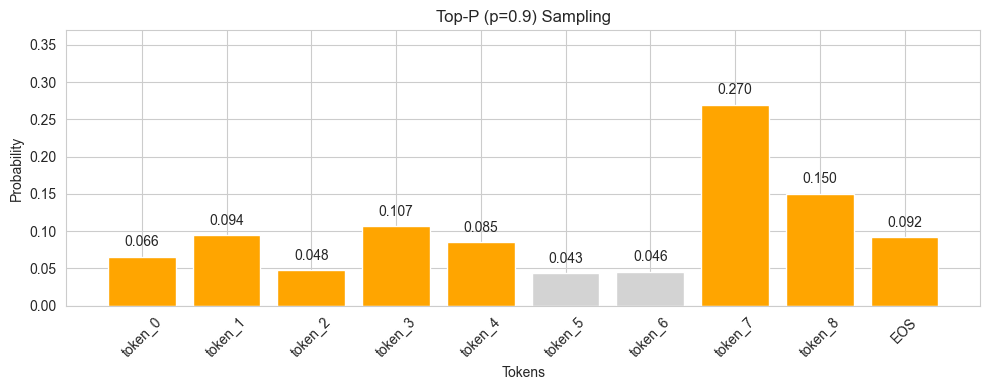

In [17]:
# Visualize Top-P
visualize_topp(model, input_tokens, p=0.9)

In [18]:
# Test Top-P sampling
print(f"Input: {model.token_to_text(input_tokens)}\n")

print("Top-P sampling (p=0.9, multiple runs):")
for _ in range(3):
    output = topp_sample(model, input_tokens, p=0.9)
    print(f"  {model.token_to_text(output)}")

Input: token_4 → token_0 → token_1

Top-P sampling (p=0.9, multiple runs):
  token_0 → token_2 → token_2 → token_5 → token_8 → token_4 → token_4 → token_5 → token_2 → EOS
  token_3 → token_4 → EOS
  token_4 → token_1 → token_6 → token_8 → token_7 → token_4 → token_6 → token_6 → token_8 → token_7


## Comparison of Sampling Methods

Let's compare all sampling methods:

In [19]:
# Compare all methods
input_tokens = np.array([4, 0, 1])
print(f"Input: {model.token_to_text(input_tokens)}\n")

print("Greedy decoding:")
output = greedy_decode(model, input_tokens)
print(f"  {model.token_to_text(output)}\n")

print("Temperature sampling (T=1.0):")
for i in range(2):
    output = temperature_sample(model, input_tokens, temperature=1.0)
    print(f"  Run {i+1}: {model.token_to_text(output)}")
print()

print("Top-K sampling (K=3):")
for i in range(2):
    output = topk_sample(model, input_tokens, k=3)
    print(f"  Run {i+1}: {model.token_to_text(output)}")
print()

print("Top-P sampling (P=0.9):")
for i in range(2):
    output = topp_sample(model, input_tokens, p=0.9)
    print(f"  Run {i+1}: {model.token_to_text(output)}")

Input: token_4 → token_0 → token_1

Greedy decoding:
  token_7 → token_7 → token_4 → token_0 → token_7 → token_2 → token_4 → EOS

Temperature sampling (T=1.0):
  Run 1: token_1 → token_7 → token_3 → token_4 → token_5 → token_3 → token_6 → token_4 → token_4 → token_0
  Run 2: token_0 → token_6 → token_4 → EOS

Top-K sampling (K=3):
  Run 1: token_8 → token_3 → token_2 → token_3 → EOS
  Run 2: token_7 → token_6 → token_8 → token_6 → token_1 → token_4 → token_2 → token_4 → token_3 → EOS

Top-P sampling (P=0.9):
  Run 1: token_8 → token_8 → token_6 → token_8 → token_4 → token_3 → token_1 → token_6 → EOS
  Run 2: token_7 → token_6 → token_4 → token_3 → token_6 → token_2 → token_4 → token_5 → token_1 → EOS


## Summary

- **Greedy Decoding**: Deterministic, always selects highest probability token
- **Temperature Sampling**: Controls randomness (higher = more random)
- **Top-K Sampling**: Restricts sampling to K most likely tokens
- **Top-P Sampling**: Adaptively selects tokens based on cumulative probability

Each method has its strengths:
- Use greedy or low temperature for factual, consistent outputs
- Use higher temperature, Top-K, or Top-P for creative, diverse outputs